<a href="https://colab.research.google.com/github/1152586743/BMI5300_Poster_Project/blob/main/BMI5300_Automatic_Data_Extraction_from_Scientific_Papers_Using_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## llama index read PDF

In [7]:
!pip -q install "llama-index-core>=0.11.0" "pymupdf>=1.23.8" "pypdf>=4.0.0" pandas


In [8]:
import sys
from pathlib import Path

print("Python:", sys.version)
DATA_DIR = Path("./BMI5300_Project")
assert DATA_DIR.exists(), f"Folder not found: {DATA_DIR.resolve()}"
pdfs = sorted(DATA_DIR.glob("*.pdf"))
print("Found PDFs:", [p.name for p in pdfs])



Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Found PDFs: ['Data Interoperability in Context- The Importance of Open-Source Implementations When Choosing Open Standards.pdf', 'Semantic Interoperability of Electronic Health Records- Systematic Review of Alternative Approaches for Enhancing Patient Information Availability.pdf', 'Standards in sync five principles to achieve semantic interoperability for TRUE research for healthcare.pdf', 'Verifying the Feasibility of Implementing Semantic Interoperability in Different Countries Based on the OpenEHR Approach- Comparative Study of Acute Coronary Syndrome Registries.pdf', 'Why digital medicine depends on interoperability.pdf', 'gavrilov-et-al-2019-healthcare-data-warehouse-system-supporting-cross-border-interoperability.pdf']


In [9]:
import fitz  # PyMuPDF
from llama_index.core import Document

documents = []
for pdf in pdfs:
    with fitz.open(pdf) as doc:
        for page_idx in range(len(doc)):
            page = doc[page_idx]
            text = page.get_text("text")
            text = text.replace("\x00", "").strip()
            if not text:
                continue
            documents.append(
                Document(
                    text=text,
                    metadata={
                        "file_name": pdf.name,
                        "page": page_idx + 1,
                        "page_label": page.number + 1
                    },
                )
            )

print(f"Loaded {len(documents)} page-documents from {len(pdfs)} PDFs.")
print("Sample meta:", documents[0].metadata)
print(documents[0].text[:500])



Loaded 57 page-documents from 6 PDFs.
Sample meta: {'file_name': 'Data Interoperability in Context- The Importance of Open-Source Implementations When Choosing Open Standards.pdf', 'page': 1, 'page_label': 1}
Viewpoint
Data Interoperability in Context: The Importance of Open-Source
Implementations When Choosing Open Standards
Daniel Kapitan1,2,3, DPhil; Femke Heddema2, MSc; André Dekker4, Prof Dr; Melle Sieswerda5, MD, MSc; Bart-Jan
Verhoeff6, MD; Matt Berg7, BA, MBA
1Eindhoven AI Systems Institute (EAISI), Eindhoven University of Technology, Eindhoven, The Netherlands
2PharmAccess Foundation, Amsterdam, The Netherlands
3Dutch Hospital Data, Utrecht, The Netherlands
4MAASTRO Clinic, Maastricht Univer


In [10]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(chunk_size=1200, chunk_overlap=150)
nodes = []
for d in documents:
    nodes.extend(splitter.get_nodes_from_documents([d]))

print(f"Total chunks (nodes): {len(nodes)}")
print(nodes[0].metadata)
print(nodes[0].get_content()[:300])


Total chunks (nodes): 81
{'file_name': 'Data Interoperability in Context- The Importance of Open-Source Implementations When Choosing Open Standards.pdf', 'page': 1, 'page_label': 1}
Viewpoint
Data Interoperability in Context: The Importance of Open-Source
Implementations When Choosing Open Standards
Daniel Kapitan1,2,3, DPhil; Femke Heddema2, MSc; André Dekker4, Prof Dr; Melle Sieswerda5, MD, MSc; Bart-Jan
Verhoeff6, MD; Matt Berg7, BA, MBA
1Eindhoven AI Systems Institute (EAIS


In [11]:
import json, pandas as pd

jsonl_path = DATA_DIR / "itc_chunks.jsonl"
csv_preview = DATA_DIR / "itc_chunks_preview.csv"

records = []
for i, n in enumerate(nodes):
    md = dict(n.metadata or {})
    records.append({
        "chunk_id": i,
        "file_name": md.get("file_name"),
        "page_label": md.get("page_label") or md.get("page"),
        "text": n.get_content(),
    })

with open(jsonl_path, "w", encoding="utf-8") as f:
    for r in records:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

pd.DataFrame(records).head(50).to_csv(csv_preview, index=False)
print("Wrote:")
print(" -", jsonl_path)
print(" -", csv_preview, "(first 50 rows)")


Wrote:
 - BMI5300_Project/itc_chunks.jsonl
 - BMI5300_Project/itc_chunks_preview.csv (first 50 rows)


In [13]:
import json
from typing import List, Dict

def load_chunks(jsonl_path="./BMI5300_Project/itc_chunks.jsonl") -> List[Dict]:
    chunks = []
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            chunks.append(json.loads(line))
    return chunks

def group_chunks_by_file(chunks: List[Dict]) -> Dict[str, List[Dict]]:
    by_file = {}
    for r in chunks:
        by_file.setdefault(r["file_name"], []).append(r)
    for k in by_file:
        by_file[k].sort(key=lambda x: (str(x.get("page_label")), x["chunk_id"]))
    return by_file

chunks = load_chunks()
by_file = group_chunks_by_file(chunks)
print(f"Loaded {len(chunks)} chunks across {len(by_file)} PDFs.")
for fname, items in by_file.items():
    print(f"{fname}: {len(items)} chunks")


Loaded 81 chunks across 6 PDFs.
Data Interoperability in Context- The Importance of Open-Source Implementations When Choosing Open Standards.pdf: 20 chunks
Semantic Interoperability of Electronic Health Records- Systematic Review of Alternative Approaches for Enhancing Patient Information Availability.pdf: 18 chunks
Standards in sync five principles to achieve semantic interoperability for TRUE research for healthcare.pdf: 9 chunks
Verifying the Feasibility of Implementing Semantic Interoperability in Different Countries Based on the OpenEHR Approach- Comparative Study of Acute Coronary Syndrome Registries.pdf: 13 chunks
Why digital medicine depends on interoperability.pdf: 9 chunks
gavrilov-et-al-2019-healthcare-data-warehouse-system-supporting-cross-border-interoperability.pdf: 12 chunks


## Google Gemini build extraction pipeline

In [14]:
!pip -q install google-generativeai>=0.7.0 pandas tqdm tenacity


In [16]:
import os, json, re, math, time
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

import google.generativeai as genai

# Read API key (env var preferred; otherwise prompt)
api_key = os.getenv("GEMINI_API_KEY")
if not api_key:
    try:
        import getpass
        api_key = getpass.getpass("Enter GEMINI_API_KEY: ")
    except Exception:
        api_key = input("Enter GEMINI_API_KEY: ")

genai.configure(api_key=api_key)

# Use a known-available generation model on your account
PREFERRED_MODELS = [
    "models/gemini-2.5-flash",
    "models/gemini-2.5-pro",
    "models/gemini-flash-latest",
    "models/gemini-pro-latest",
]

available = [m for m in genai.list_models() if "generateContent" in m.supported_generation_methods]
available_names = [m.name for m in available]

def pick_model():
    for pref in PREFERRED_MODELS:
        if pref in available_names:
            return pref
    if available_names:
        return available_names[0]
    raise RuntimeError("No Gemini model with generateContent available for this key.")

MODEL_NAME = pick_model()
print("Using model:", MODEL_NAME)

model = genai.GenerativeModel(
    MODEL_NAME,
    generation_config={
        "response_mime_type": "application/json"  # ask for JSON directly
    }
)

# Paths
DATA_DIR = Path("./BMI5300_Project")
JSONL_CHUNKS = DATA_DIR / "itc_chunks.jsonl"   # produced by your LlamaIndex step
RAW_OUT      = DATA_DIR / "itc_extractions_raw.jsonl"
CSV_OUT      = DATA_DIR / "itc_extracted.csv"

assert JSONL_CHUNKS.exists(), f"Missing {JSONL_CHUNKS}. Run the LlamaIndex chunking step first."


Enter GEMINI_API_KEY: ··········
Using model: models/gemini-2.5-flash


In [17]:
import re, json, math, string
from collections import defaultdict, Counter
import pandas as pd

# ---- Prompt for "challenge" phrases ----
CHALLENGE_SYSTEM = """\
You are an expert in health informatics. From the given text about worldwide healthcare data
semantic interoperability, extract the *challenges/barriers* as short noun phrases (3–8 words each).

Rules:
- Output ONLY a JSON object of the form: {"challenges": ["...", "...", ...]}
- Include only concrete barriers (e.g., "terminology mapping inconsistencies", "data quality variability",
  "cross-border privacy regulations", "profile version drift", "lack of open-source tooling", "licensing barriers",
  "multilingual vocabulary gaps", "infrastructure limitations", "governance and stewardship fragmentation").
- Avoid generic or positive items (no benefits, methods, solutions). Do not include duplicates.
- Be conservative; if the text does not discuss challenges, return an empty list.
"""

def build_challenge_prompt(file_name, page_label, chunk_text):
    return (
        CHALLENGE_SYSTEM
        + "\n\n<chunk file=\"%s\" page=\"%s\">\n%s\n</chunk>\n\nReturn ONLY the JSON object."
          % (file_name, page_label, chunk_text[:6000])
    )

def parse_challenge_json(text: str) -> dict:
    try:
        return json.loads(text)
    except:
        m = re.search(r"\{.*\}", text, flags=re.S)
        if not m:
            return {"challenges": []}
        try:
            return json.loads(m.group(0))
        except:
            return {"challenges": []}

def call_gemini_challenges(prompt: str) -> list[str]:
    resp = model.generate_content(prompt)
    raw = getattr(resp, "text", "") or ""
    obj = parse_challenge_json(raw.strip())
    vals = obj.get("challenges") or []
    # normalize empties
    out = []
    for v in vals:
        if isinstance(v, str):
            v2 = v.strip()
            if v2:
                out.append(v2)
    return out


In [18]:
# keyword hints for "challenge-y" paragraphs
CHALLENGE_HINTS = [
    r"\bchallenge(s)?\b", r"\bbarrier(s)?\b", r"\bobstacle(s)?\b", r"\blimitation(s)?\b",
    r"\brisk(s)?\b", r"\bissue(s)?\b", r"\bgap(s)?\b", r"\bshortcoming(s)?\b", r"\bconstraint(s)?\b",
    # domain-specific hot words:
    r"\bterminology\b", r"\bmapping\b", r"\bsemantic\b", r"\bheterogeneity\b",
    r"\bdata quality\b", r"\bstandard(s)?\b", r"\bFHIR\b", r"\bopenEHR\b", r"\bOMOP\b",
    r"\bprofile(s)?\b", r"\bversion(ing)?\b", r"\bgovernance\b", r"\bstewardship\b",
    r"\bprivacy\b", r"\bsecurity\b", r"\bconsent\b", r"\blicens(e|ing)\b",
    r"\bpolicy\b", r"\bregulation(s)?\b", r"\bcross[- ]border\b", r"\bmultilingual\b",
    r"\btranslation\b", r"\blocalization\b", r"\bcode set\b", r"\bSNOMED\b", r"\bLOINC\b",
    r"\binfrastructure\b", r"\bresourcing\b", r"\bopen-source\b", r"\btool(ing)?\b",
]
CHALLENGE_HINTS = [re.compile(k, re.I) for k in CHALLENGE_HINTS]

def score_challenge_chunk(text: str) -> int:
    t = text or ""
    return sum(len(k.findall(t)) for k in CHALLENGE_HINTS)

# group by file
by_file = defaultdict(list)
for r in chunks:
    by_file[r["file_name"]].append(r)

TOP_N = 10  # top-N chunks per file to send to Gemini (tweak if needed)

scored_selection = {}
for fname, items in by_file.items():
    scored = [(score_challenge_chunk(r.get("text","")), r) for r in items]
    scored.sort(key=lambda x: (-x[0], str(x[1].get("page_label")), x[1].get("chunk_id")))
    scored_selection[fname] = [r for _, r in scored[:TOP_N]]


In [19]:
from tqdm import tqdm

RAW_CHALLENGE_JSONL = DATA_DIR / "challenge_extractions_raw.jsonl"
PER_FILE_CSV        = DATA_DIR / "per_file_challenges.csv"
COUNTS_CSV          = DATA_DIR / "challenge_counts.csv"

raw_lines = []
per_file_phrases = defaultdict(list)

for fname, selected in tqdm(scored_selection.items(), desc="Files"):
    seen_local = set()
    for r in selected:
        prompt = build_challenge_prompt(
            file_name=r.get("file_name"),
            page_label=r.get("page_label"),
            chunk_text=r.get("text","")
        )
        try:
            phrases = call_gemini_challenges(prompt)
        except Exception as e:
            phrases = []
        # audit
        raw_lines.append(json.dumps({
            "file_name": fname,
            "chunk_id": r.get("chunk_id"),
            "page_label": r.get("page_label"),
            "challenges": phrases
        }, ensure_ascii=False))
        # collect unique per-file
        for p in phrases:
            key = p.strip()
            if key and key.lower() not in seen_local:
                per_file_phrases[fname].append(key)
                seen_local.add(key.lower())

# write raw jsonl
with open(RAW_CHALLENGE_JSONL, "w", encoding="utf-8") as f:
    f.write("\n".join(raw_lines))
print("Wrote raw per-chunk extractions to:", RAW_CHALLENGE_JSONL)

# make per-file dataframe
rows = []
for fname, plist in per_file_phrases.items():
    for p in plist:
        rows.append({"file_name": fname, "challenge_phrase": p})
per_file_df = pd.DataFrame(rows).sort_values(["file_name","challenge_phrase"])
per_file_df.to_csv(PER_FILE_CSV, index=False)
print("Wrote per-file challenge list to:", PER_FILE_CSV)

# global counts (before canonicalization)
counts = Counter([p for _, p in rows])
counts_df = pd.DataFrame(
    [{"challenge_phrase": k, "count": v} for k,v in counts.most_common()]
)
counts_df.to_csv(COUNTS_CSV, index=False)
print("Wrote raw frequency table to:", COUNTS_CSV)

counts_df.head(20)


Files: 100%|██████████| 6/6 [04:47<00:00, 47.99s/it]

Wrote raw per-chunk extractions to: BMI5300_Project/challenge_extractions_raw.jsonl
Wrote per-file challenge list to: BMI5300_Project/per_file_challenges.csv
Wrote raw frequency table to: BMI5300_Project/challenge_counts.csv


,challenge_phrase,count
0,challenge_phrase,148


In [20]:
# simple canonicalization helpers
def normalize_phrase(p: str) -> str:
    p = p.lower().strip()
    p = p.translate(str.maketrans("", "", string.punctuation))
    p = re.sub(r"\s+", " ", p)
    return p

CANON_MAP = [
    # (pattern, canonical_bucket)
    (r"(terminolog(y|ies)|vocab(ulary)?|code ?set|snomed|loinc|icd).*(mapp|align|harmoniz)", "terminology mapping inconsistencies"),
    (r"data (heterogen|fragment|silo|variet)", "data heterogeneity"),
    (r"data (quality|completeness|accuracy|lineage|provenance)", "data quality & provenance"),
    (r"(profile|implementation guide).*(drift|version|upgrade|compatib)", "profile version drift / upgrades"),
    (r"(standard|sdo|hl7|fhir|openehr|omop).*(misalign|harmoniz|govern)", "standards misalignment & governance"),
    (r"(privacy|security|consent|hipaa|gdpr|policy|regulation)", "privacy, security & consent regulations"),
    (r"(cross[- ]?border|international|jurisdiction|policy difference)", "cross-border regulatory differences"),
    (r"(multilingual|locali[sz]ation|translation)", "multilingual terminology & localization"),
    (r"(tool|validator|server|open[- ]?source|infrastructure|resource|capacity)", "tooling, infrastructure & resource gaps"),
    (r"(licens|ip|copyright)", "licensing & IP barriers"),
]

def canonicalize(p: str) -> str:
    n = normalize_phrase(p)
    for pat, bucket in CANON_MAP:
        if re.search(pat, n):
            return bucket
    return "other / uncategorized"

# apply mapping
per_file_df["canonical_challenge"] = per_file_df["challenge_phrase"].apply(canonicalize)

CANON_COUNTS_CSV = DATA_DIR / "challenge_counts_canonical.csv"
canon_counts = per_file_df["canonical_challenge"].value_counts().reset_index()
canon_counts.columns = ["canonical_challenge", "count"]
canon_counts.to_csv(CANON_COUNTS_CSV, index=False)
print("Wrote canonical counts to:", CANON_COUNTS_CSV)

# per-file x canonical pivot (helps your poster summary table)
PIVOT_CSV = DATA_DIR / "per_file_canonical_pivot.csv"
pivot = (per_file_df
         .assign(x=1)
         .pivot_table(index="file_name", columns="canonical_challenge", values="x", aggfunc="sum", fill_value=0)
         .reset_index())
pivot.to_csv(PIVOT_CSV, index=False)
print("Wrote per-file × canonical pivot to:", PIVOT_CSV)

canon_counts


Wrote canonical counts to: BMI5300_Project/challenge_counts_canonical.csv
Wrote per-file × canonical pivot to: BMI5300_Project/per_file_canonical_pivot.csv


,canonical_challenge,count
0,other / uncategorized,117
1,"tooling, infrastructure & resource gaps",14
2,"privacy, security & consent regulations",4
3,licensing & IP barriers,4
4,multilingual terminology & localization,4
5,data quality & provenance,3
6,standards misalignment & governance,1
7,cross-border regulatory differences,1


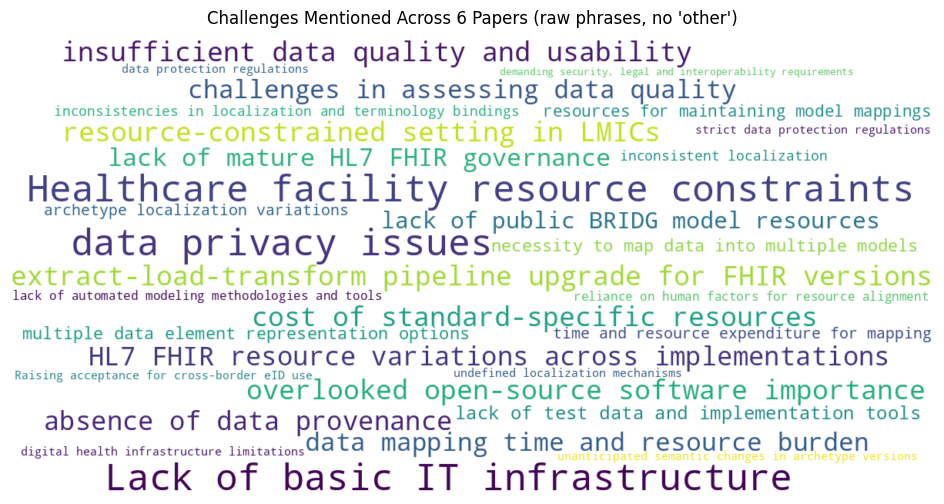

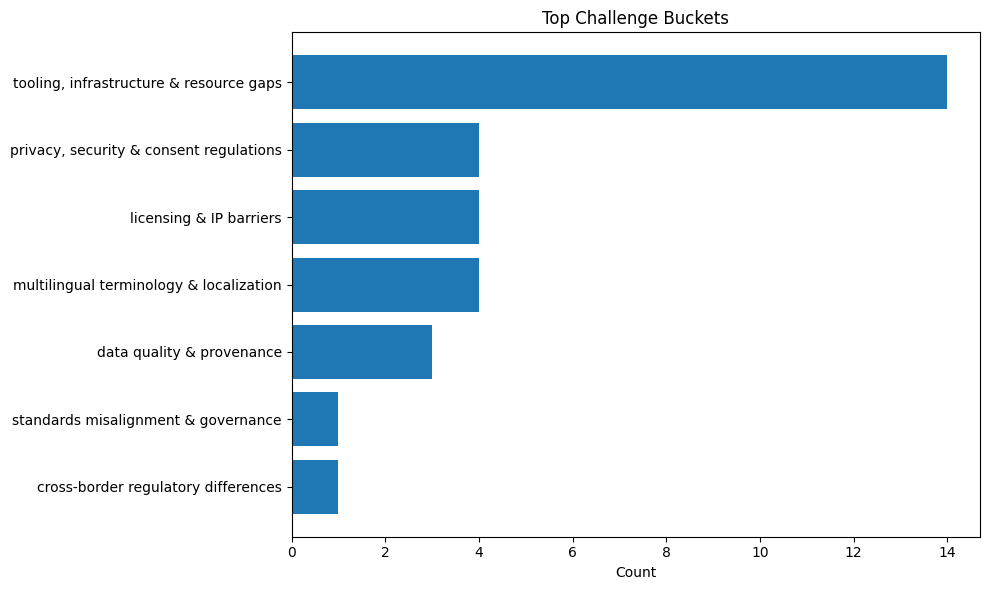

In [23]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

NO_OTHER = "other / uncategorized"
pf_no_other = per_file_df[per_file_df["canonical_challenge"] != NO_OTHER]

freq = Counter(pf_no_other["challenge_phrase"])
wc = WordCloud(width=1200, height=600, background_color="white")
wc.generate_from_frequencies(freq)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Challenges Mentioned Across 6 Papers (raw phrases, no 'other')")
plt.show()

canon_no_other = (pf_no_other["canonical_challenge"]
                  .value_counts()
                  .reset_index())
canon_no_other.columns = ["canonical_challenge", "count"]

topN = 15
plot_df = canon_no_other.head(topN)

plt.figure(figsize=(10,6))
plt.barh(plot_df["canonical_challenge"], plot_df["count"])
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("Top Challenge Buckets")
plt.tight_layout()
plt.show()

